In [1]:
import time
from tqdm import tqdm
from multiprocessing import Pool
from sklearn import preprocessing
from obspy.signal.headers import clibsignal


import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MultipleLocator, FormatStrFormatter,ScalarFormatter
from matplotlib.dates import YearLocator, MonthLocator, DayLocator, HourLocator, MinuteLocator, SecondLocator, DateFormatter
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import obspy as op
from obspy import read,read_inventory, UTCDateTime, Stream, Trace
from obspy.clients.fdsn.client import Client
from obspy.signal.rotate import rotate_ne_rt
from obspy.geodetics import gps2dist_azimuth,kilometers2degrees
from obspy.taup import TauPyModel
from obspy.imaging.beachball import beachball,beach

import json
import glob
import os
import numpy as np
from itertools import combinations
import pandas as pd
from scipy.signal import spectrogram, detrend, resample,savgol_filter,decimate,hilbert
from scipy.stats import circmean, circstd

import pyarrow.feather as feather
import seaborn as sns

import datetime

____________
# Setup
____________

In [2]:
# ===========
# DIRECTORIES
# ===========

## ----------------------------
## Directory of the StationXML:

XML_DIR = '/home/sysop/dados_posdoc/PROJETO_RSBR_15_YEARS/XML/'

## -----------------------
## Directory of the output (Figures and Feathers file)

ORIENTATION_OUTPUT = '/home/sysop/dados_posdoc/PROJETO_RSBR_15_YEARS/OUTPUT/'

# ==========
# PARAMETERS
# ==========

## -------------------------------------------------------------------
## Apply band-pass filtering to the seismograms using the range above:

PERIOD_BANDS = [0.02,0.5]

## ===================================================================================
## Default parameters to define the signal and noise windows used to estimate the SNR:

## ------------------------------------------------------------------------------
## Duration of the signal window before and after the P-wave arrival (in seconds)

TIME_WINDOW = 120

## -----------------------------------------------------------------------------------
## End time of the P-wave window (in seconds after P-wave arrival)

TIME_FINAL_P = 5

## ---------------------------------------------
## Minimum earthquake magnitude to be considered

minmagnitude = 6

## -----------------
## Region parameters

LLCRNRLON_LARGE = -50
URCRNRLON_LARGE = -38
LLCRNRLAT_LARGE = -30
URCRNRLAT_LARGE = -12

## ---------
## Constants

ONEDAY = datetime.timedelta(days=1)

## ---------------
## MULTIPROCESSINGoutput_FEATHER_FILES_ORIENTATION

num_processes = 20

## --------------------------------------
## Generate a figure for each estimation?

VERBOSE = True

---
# Functions

---
# Main program
---

In [8]:
print('================')
print('Reading stations')
print('================')
print('\n')

STATIONS_xml = sorted(glob.glob(XML_DIR+'*BR.ITTB*'))
STATIONS_xml = STATIONS_xml
print('Number of stations:',len(STATIONS_xml))

Reading stations


Number of stations: 1


In [9]:
STATIONS_lst = [i.split('/')[-1].split('.d')[0] for i in STATIONS_xml]

In [10]:
STATIONS_lst

['BR.ITTB']

In [11]:
def plotting_event_orientation(df_row,ORIENTATION_OUTPUT='/home/sysop/dados_posdoc/PROJETO_RSBR_15_YEARS/OUTPUT/'):
    df_row = df_row[1]

    # -------------------------------------------
    # Function estimates the Akaike Information directly from data 
    # For a given time series
    # The Summed Log Likelihood section implies that a natural 
    # changepoint estimate is the sample index that minimizes 
    # the AIC in equation
    
    aic_curve = df_row['aic_curve']

    k_min_index = np.argmin(aic_curve)
                            
    amp_P_arr = aic_curve[k_min_index]
    time_P_arr = df_row['clock_error']
    
    # Time instability:
    time_ins = df_row['clock_error']

    if time_ins > 0:
        signal_window_start = time_ins
        signal_window_final = time_ins+TIME_FINAL_P
        noise_window_start = time_ins
        noise_window_final = time_ins-TIME_FINAL_P
    else:
        signal_window_start = time_ins
        signal_window_final = TIME_FINAL_P+time_ins
        noise_window_start = time_ins
        noise_window_final = -(abs(time_ins)+TIME_FINAL_P) 
    # -------------------------------------------------------------------------------------------------------------------------------
    # Signal and noise windows
            
    signal_window = (df_row['trZ_time'] >= signal_window_start) & (df_row['trZ_time'] <= signal_window_final)
    noise_window = (df_row['trZ_time'] >= noise_window_final) & (df_row['trZ_time'] <= noise_window_start)
                                    
    noise = df_row['trZ_data'][noise_window]
    trZ_noise_time = df_row['trZ_time'][noise_window]
            
    tr2 = df_row['tr2_data'][signal_window]
    tr1 = df_row['tr1_data'][signal_window]
    trZ = df_row['trZ_data'][signal_window]
    trZ_signal_time = df_row['trZ_time'][signal_window]
                
    # --------------------
    # figure 
    fig = plt.figure(figsize=(15, 10),constrained_layout=True)

    qc_symbol = '[✔]' if df_row['quality'] == 'good' else '[✘]'

    fig.suptitle(
    f"{qc_symbol} Evento: {df_row['evname']} "
    f"(Δ: {round(df_row['gcarc'])}° | M: {round(df_row['evmag'])} {df_row['evtype']} | "
    f"D: {round(df_row['evdp'])} km | C: {df_row['event_class']}) \n "
    f"SNR: {df_row['SNR']} dB | BAZ: {round(df_row['baz'])}° | "
    f"PHI: {df_row['phi']}° | theta: {df_row['theta']}° | "
    f"TI: {df_row['clock_error']}s | "
    f"GN: {df_row['gain_HHN']:.2e} | GE: {df_row['gain_HHE']:.2e}  | GZ: {df_row['gain_HHZ']:.2e}", 
    fontsize=15)    
    
    # creating grid
    gs = fig.add_gridspec(1, 2,width_ratios=[3,1])

    gs0 = gs[0].subgridspec(4, 1)
    gs1 = gs[1].subgridspec(4, 1)
                                
    # Rotating components
    new_R, new_T = rotate_ne_rt(df_row['tr1_data'], df_row['tr2_data'], df_row['phi'])

    # Transversal data
    ax1 = fig.add_subplot(gs0[0, 0])
    ax1.plot(df_row['trZ_time'],new_T,'-k',lw=2,label='HHT')
    ax1.plot(trZ_signal_time,tr2,c='gray',ls='--',lw=1,label='HHE')
    ax1.axvspan(xmin=signal_window_start, xmax=signal_window_final, ymin=0, ymax=1,facecolor='none', edgecolor='blue', linestyle='--', lw=2,alpha=0.25)
    ax1.annotate(df_row['network']+'.'+df_row['station']+'..HHT', (0.95, 0.85),xycoords='axes fraction',fontsize=15, va='center',ha='right',bbox=dict(boxstyle="round", fc="white"))
    ax1.set_xlim(-TIME_WINDOW,TIME_WINDOW)
    ax1.tick_params(axis="x", labelbottom=False)
    ax1.grid(which='major',linestyle=':')
    ax1.legend(loc='lower left')

    # Radial data
    ax2 = fig.add_subplot(gs0[1, 0], sharex=ax1, sharey=ax1)
    ax2.plot(df_row['trZ_time'],new_R,'-k',label='HHR')
    ax2.plot(trZ_signal_time,tr1,c='gray',ls='--',lw=1,label='HHN')
    ax2.axvspan(xmin=signal_window_start, xmax=signal_window_final, ymin=0, ymax=1,facecolor='none', edgecolor='blue', linestyle='--', lw=2,alpha=0.25)
    ax2.annotate(df_row['network']+'.'+df_row['station']+'..HHR', (0.95, 0.85),xycoords='axes fraction',fontsize=15, va='center',ha='right',bbox=dict(boxstyle="round", fc="white"))
    ax2.tick_params(axis="x", labelbottom=False)
    ax2.grid(which='major',linestyle=':')
    ax2.legend(loc='lower left')

    # Vertical data and noise and signal window
    ax3 = fig.add_subplot(gs0[2, 0], sharex=ax1, sharey=ax1)
    ax3.plot(df_row['trZ_time'],df_row['trZ_data'],'-k')
    ax3.tick_params(axis="x", labelbottom=False)
    ax3.annotate(df_row['network']+'.'+df_row['station']+'..HHZ', (0.95, 0.85),xycoords='axes fraction',fontsize=15, va='center',ha='right',bbox=dict(boxstyle="round", fc="white"))
    ax3.axvspan(xmin=signal_window_start, xmax=signal_window_final, ymin=0, ymax=1,facecolor='none', edgecolor='blue', linestyle='--', lw=2,alpha=0.25,label='signal')
    ax3.axvspan(xmin=noise_window_start, xmax=noise_window_final, ymin=0, ymax=1,facecolor='none', edgecolor='red', linestyle='--', lw=2,alpha=0.25,label='noise')
    ax3.grid(which='major',linestyle=':')
    ax3.legend(loc='lower left')

    # Vertical data AIC curve
    ax4 = fig.add_subplot(gs0[3, 0], sharex=ax1)
    ax4.plot(df_row['trZ_time'],aic_curve, 'k')
    ax4.scatter(time_P_arr,amp_P_arr, marker='v',s=100,c='k',lw=1,ec='r',label='changepoint')
    ax4.annotate('AIC', (0.95, 0.85),xycoords='axes fraction',fontsize=15, va='center',ha='right',bbox=dict(boxstyle="round", fc="white"))
    ax4.set_xlabel('Timelag (s)',fontsize=15)
    ax4.grid(which='major',linestyle=':')                          
    ax4.legend(loc='lower left')
    ax4.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax4.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    
    # --------------------
    # Search Space of BAZ

    # Step size for the azimuth search (in degrees).
    dphi = 0.1

    # Array of azimuth angles to search through (in degrees).
    ang = np.arange(0., 360., dphi)
    
    # --------------------  
    # Transversal signal strength
    
    ax5 = fig.add_subplot(gs1[0, 0])
    ax5.plot(ang,df_row['signal_strength'],'.k')
    ax5.plot(df_row['phi'],df_row['SS_best'],'*r',ms=10)
    ax5.set_ylim(0,1)
    ax5.set_xlim(0,360)
    ax5.tick_params(axis="x", labelbottom=False)
    ax5.set_title('SS HHT',fontsize=15)
    ax5.grid(which='major',linestyle=':')                          
                                
    # Similarity between vertical and radial
    ax6 = fig.add_subplot(gs1[1, 0],sharex=ax5)
    ax6.plot(ang,df_row['similarity_vertical_radial'],'.k')
    ax6.plot(df_row['phi'],df_row['SZR_best'],'*r',ms=10)
    ax6.set_ylim(-1,1)
    ax6.tick_params(axis="x", labelbottom=False)
    ax6.set_title('CC HHZ-HHR',fontsize=15)
    ax6.grid(which='major',linestyle=':')                          

    # Transverse-to-Radial Energy Ratio
    ax7 = fig.add_subplot(gs1[2, 0],sharex=ax5)
    ax7.plot(ang,df_row['energy_transverse_radial'],'.k')
    ax7.plot(df_row['phi'],df_row['ERTR_best'],'*r',ms=10)
    ax7.tick_params(axis="x", labelbottom=False)
    ax7.set_title('1-(HHT/HHR)',fontsize=15)
    ax7.grid(which='major',linestyle=':')                          
                                                                
    # Radial-to-Vertical Energy Ratio
    ax8 = fig.add_subplot(gs1[3, 0],sharex=ax5)
    ax8.plot(ang,df_row['energy_radial_vertical'],'.k')
    ax8.plot(df_row['phi'],df_row['ERRZ_best'],'*r',ms=10)
    ax8.set_title('1-(HHR/HHZ)',fontsize=15)
    ax8.set_xlabel('Orientation Angle (deg)',fontsize=15)
    ax8.grid(which='major',linestyle=':')                          
    ax8.tick_params(axis="both", which='both',labelbottom=True, labelright=True, labelleft=True, labeltop=False,bottom=True, top=True, left=True, right=True)

    # --------------------------
    # Adding global location map

    ax_map = plt.axes([0.025, 0.78, 0.12, 0.12], projection=ccrs.Orthographic(central_latitude=df_row['stla'],central_longitude=df_row['stlo']))
    ax_map.set_global()

    # ---------------------
    # Adding background map 

    ax_map.add_feature(cfeature.LAND)
    ax_map.add_feature(cfeature.OCEAN)
    ax_map.add_feature(cfeature.COASTLINE)
                            
    ax_map.scatter(df_row['evlo'],df_row['evla'],color="y",marker='*',s=200,ec='k',transform=ccrs.PlateCarree())
    ax_map.scatter(df_row['stlo'],df_row['stla'],color="r",marker='^',s=50,transform=ccrs.PlateCarree())
    ax_map.plot([df_row['stlo'], df_row['evlo']], [df_row['stla'], df_row['evla']], c='gray',ls='-',lw=2, transform=ccrs.Geodetic())
   
    # ===================================================================================
    # focal mechanism (https://docs.obspy.org/tutorial/code_snippets/beachball_plot.html)
    # ===================================================================================
                                    
    # ---------------------------
    # Plotting: adding a new axes
                                    
    newax = fig.add_axes([-0.06, 0.4, 0.3,  0.3])
    
    # -----------------------------------------
    # Computing: Retrieving moment tensor info
                                            
    mt = df_row['moment tensor'] 
    
    # -----------------------------------------------------------------------------------------------------------------------------------------
    # Plotting: graphical representation of a focal mechanism (https://docs.obspy.org/packages/autogen/obspy.imaging.beachball.beachball.html)

    # Normalize event depth values between 0 and 600 km:
    min_val = 0
    max_val = 600
    normalized_values = [(x - min_val) / (max_val - min_val) for x in np.arange(min_val, max_val,10)]

    # Colormap "Plasma" for each value
    colors = [plt.cm.Spectral(value) for value in normalized_values]
                                                                        
    # Convert colors RGB to hexadecimal:
    hex_colors = [mcolors.rgb2hex(color) for color in colors]

    # Find the color for a given depth
    diff_ev_depth = [np.abs(numero - df_row['evdp']) for numero in np.arange(min_val, max_val,10)]
                                        
    # Find the min index for a given depth
    index_min_ev_depth = diff_ev_depth.index(min(diff_ev_depth))

    # Plotting the hexcolor
    bball = beach(fm=mt, xy=(0, 0.5),size=200, width=0.75, facecolor=hex_colors[index_min_ev_depth])
        
    # -------------------------
    # Plotting: axes parameters 
                                
    newax.add_collection(bball)
    newax.set_xlim(-1, 1)
    newax.set_ylim(-1, 1)
    newax.set_aspect('equal')
    newax.axis('off')
        
    # ===========================================================
    # ray paths (https://docs.obspy.org/packages/obspy.taup.html)
    # ===========================================================

    # ---------------------------------------------------------------------------------------------------
    # Computing: The paths travelled by the rays to the receiver for a given phase and 1D velocity model 
    
    model = TauPyModel(model="iasp91")
    arrivals_ray_path = model.get_ray_paths(source_depth_in_km=df_row['evdp'], distance_in_degree=df_row['gcarc'], phase_list=['P','PKP','PKIKP'])

    # -------------------------
    # Plotting: axes parameters 
                                    
    ax_raypath = fig.add_axes([0.022, 0.32, 0.13,  0.13], projection='polar')
    arrivals_ray_path.plot_rays(ax=ax_raypath)
        
    # ==========================================
    
    output_figure_ORIENTATION = ORIENTATION_OUTPUT+'ORIENTATION_FIGURES/EARTHQUAKES/'+df_row['network']+'.'+df_row['station']+'/'
    os.makedirs(output_figure_ORIENTATION,exist_ok=True)
    fig.savefig(output_figure_ORIENTATION+'ORIENTATION_'+df_row['station']+'_'+df_row['evname']+'_'+df_row['quality']+'.png',dpi=100)
    plt.close()

Processsing station:  BR.ITTB


 43%|█████████████████▊                       | 300/690 [00:45<00:55,  6.98it/s]/home/sysop/Programs/anaconda3/lib/python3.12/site-packages/obspy/imaging/beachball.py:48: UserWarning: Encountered an exception while plotting the beachball. Falling back to the mopad wrapper which is slower but more stable.
  warnings.warn(msg)
 46%|██████████████████▋                      | 314/690 [00:47<00:43,  8.72it/s]

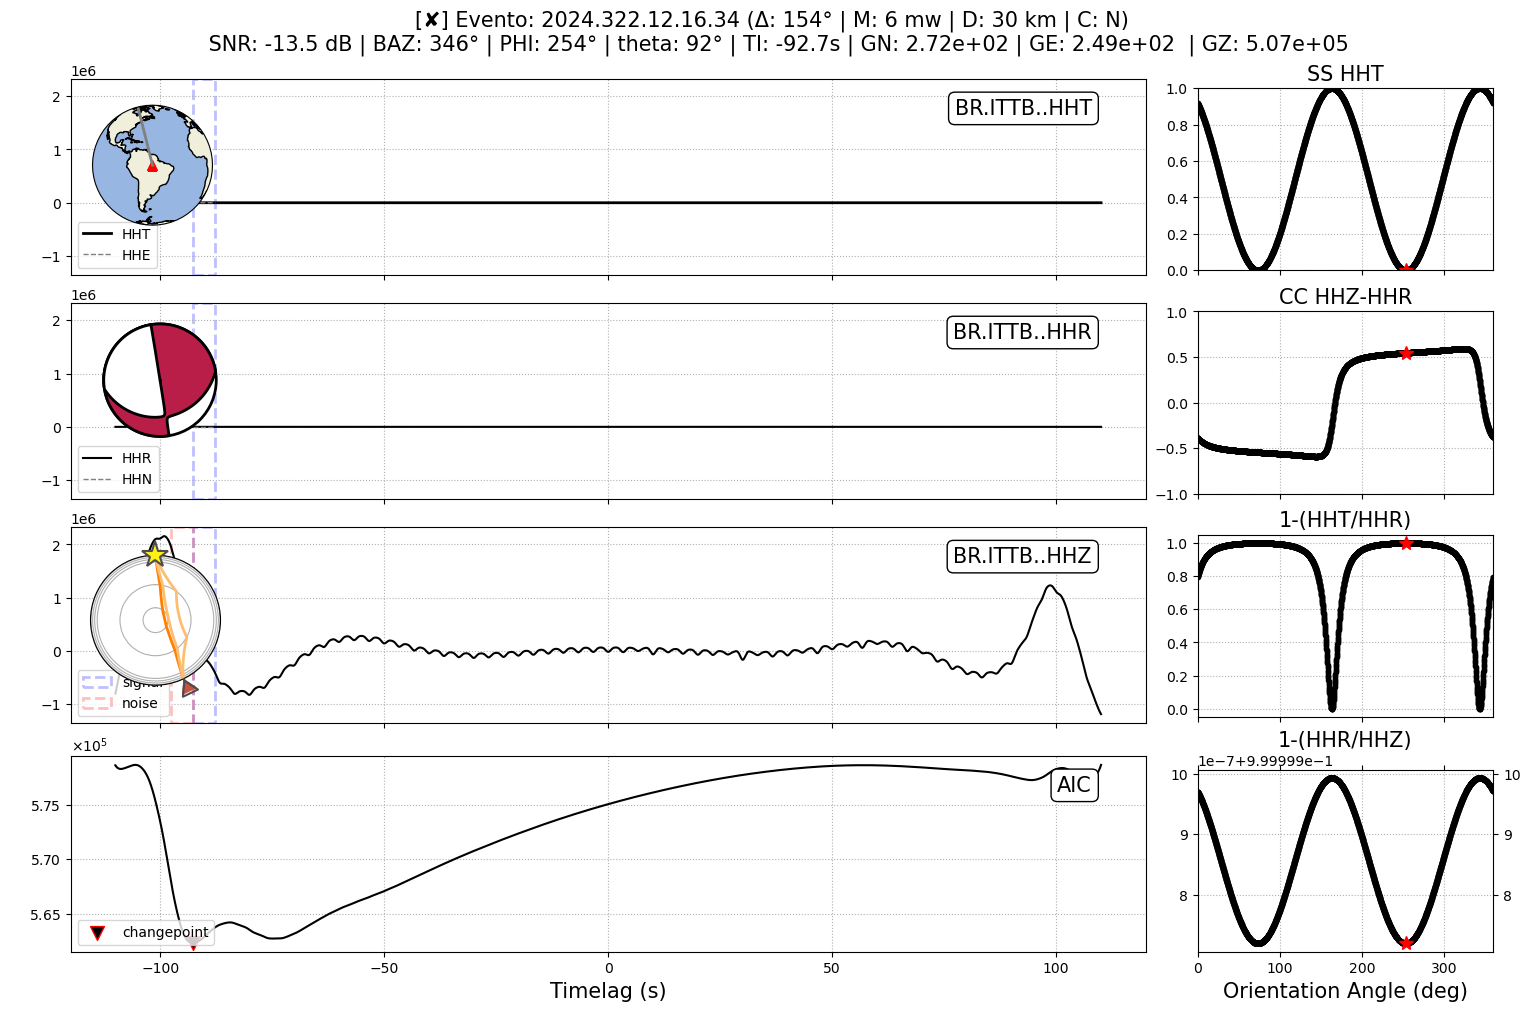

 49%|████████████████████                     | 337/690 [00:51<01:02,  5.66it/s]

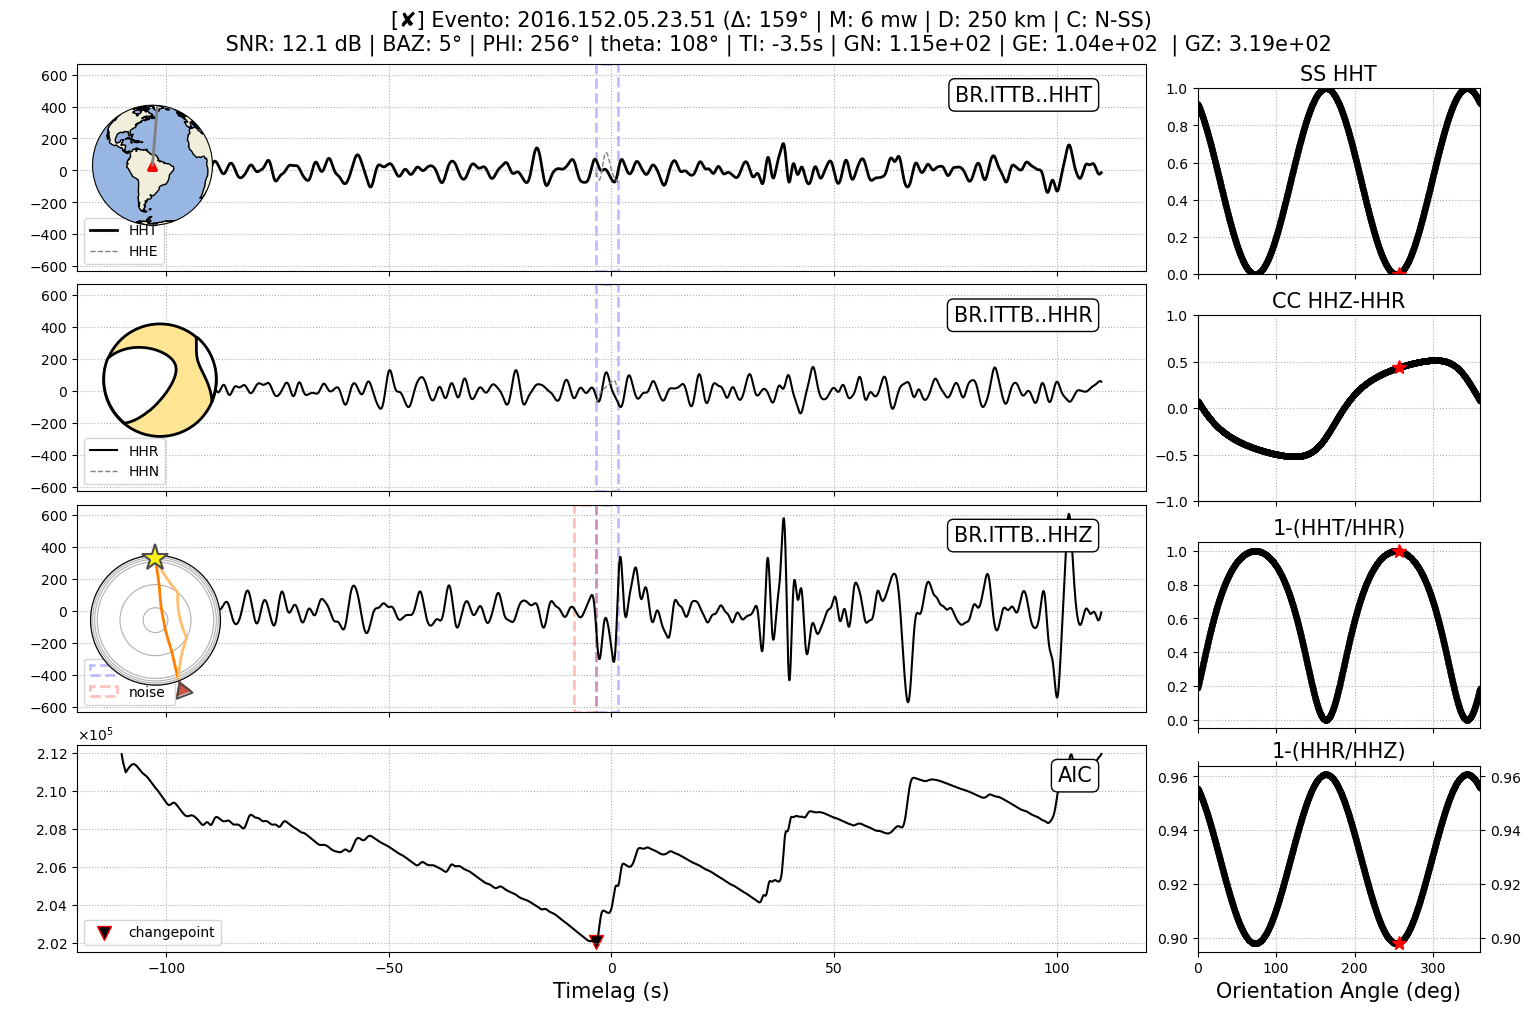

 52%|█████████████████████▎                   | 358/690 [00:54<01:07,  4.95it/s]

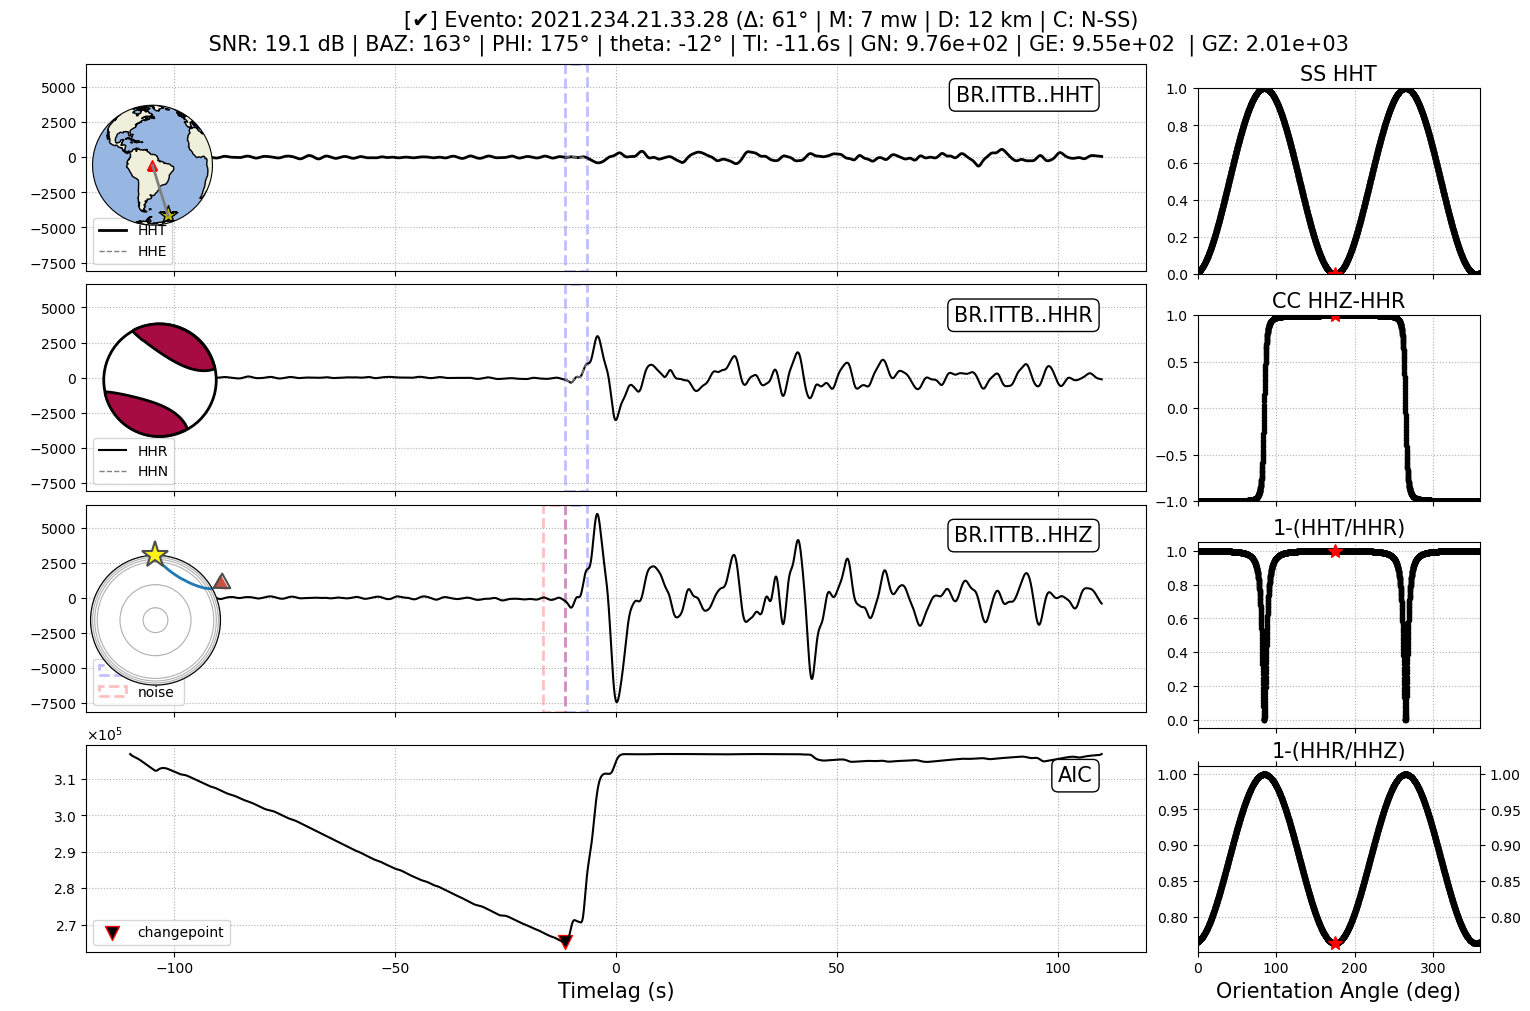

 54%|██████████████████████▎                  | 376/690 [00:57<00:51,  6.04it/s]

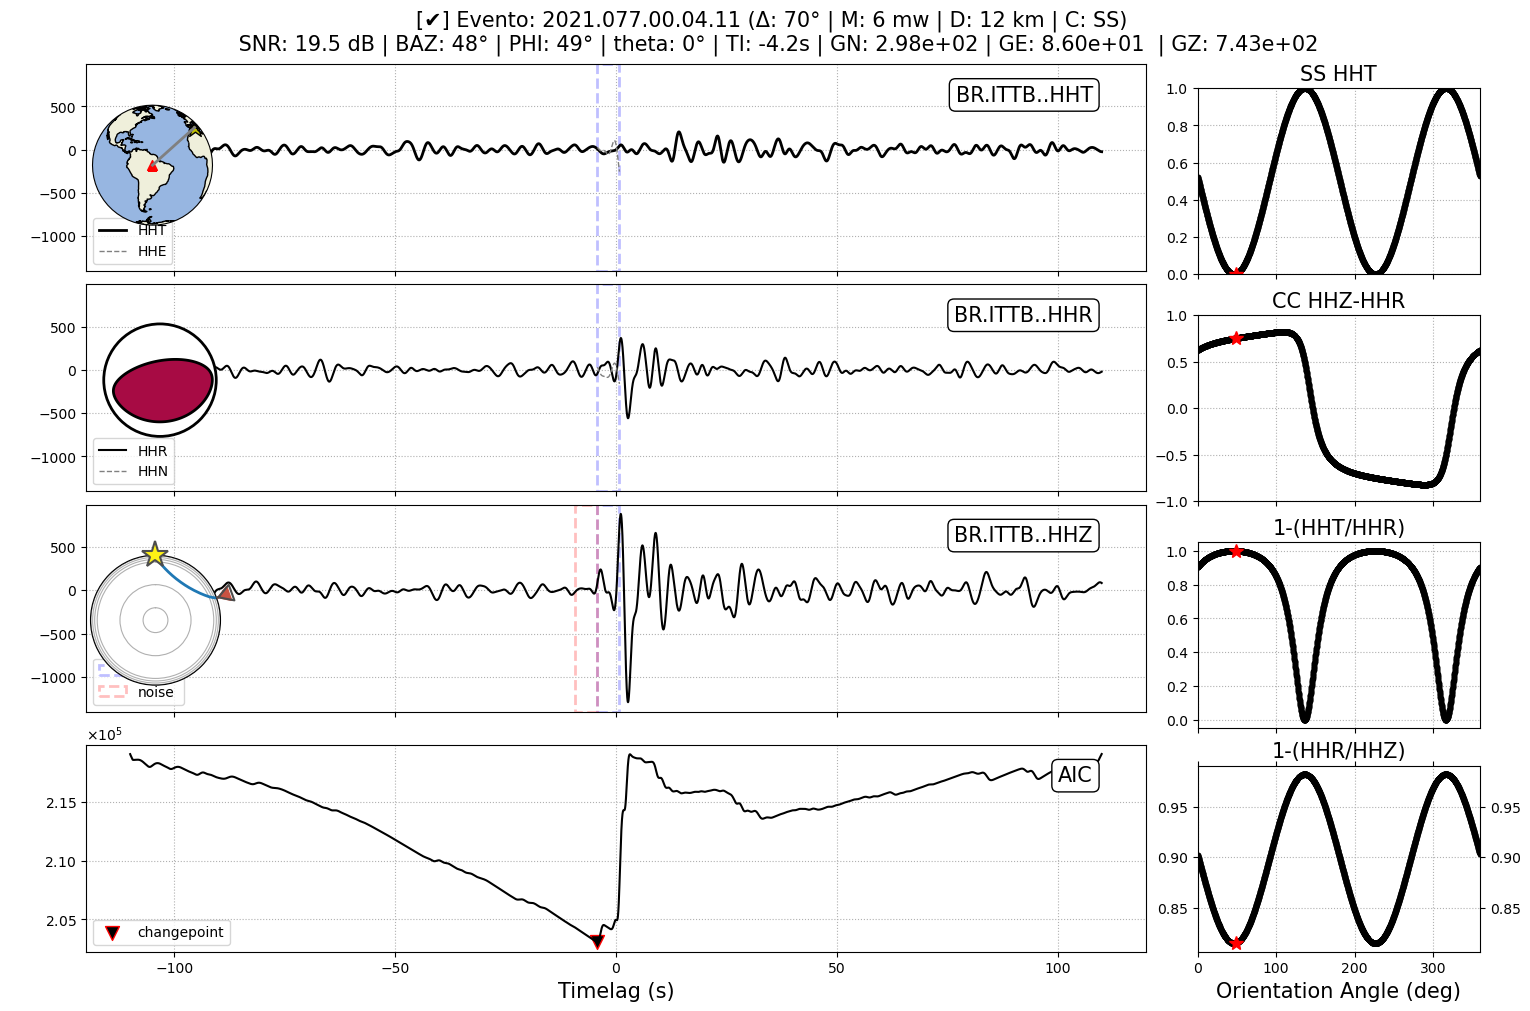

 57%|███████████████████████▎                 | 393/690 [01:00<00:59,  5.02it/s]

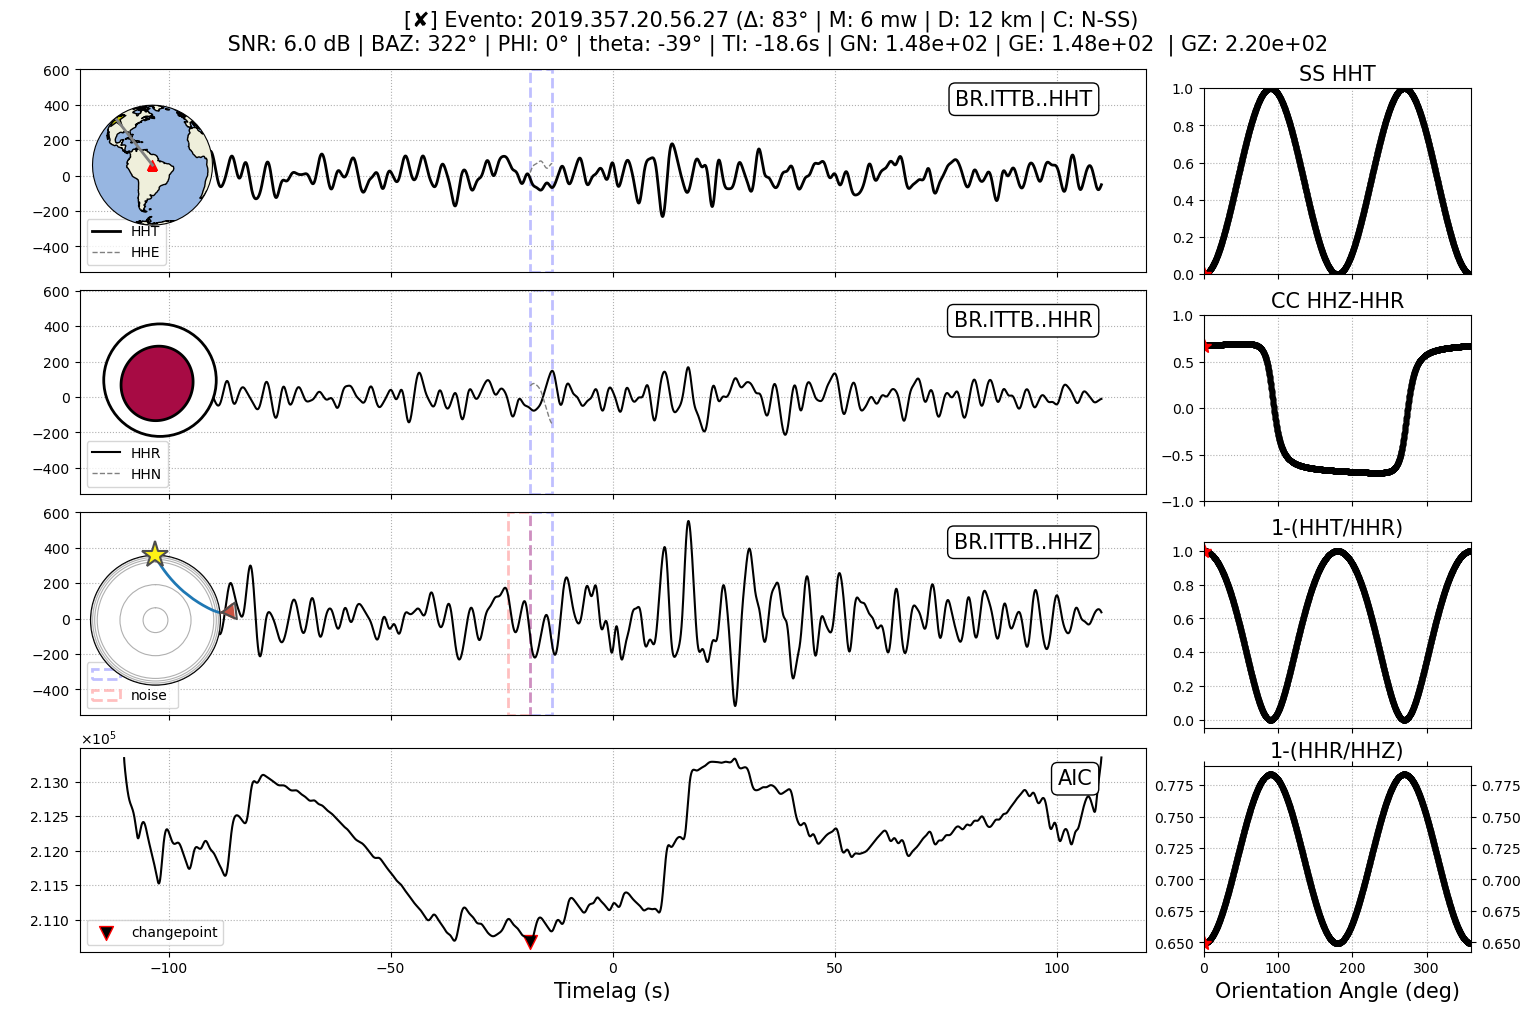

 60%|████████████████████████▍                | 411/690 [01:03<01:02,  4.43it/s]

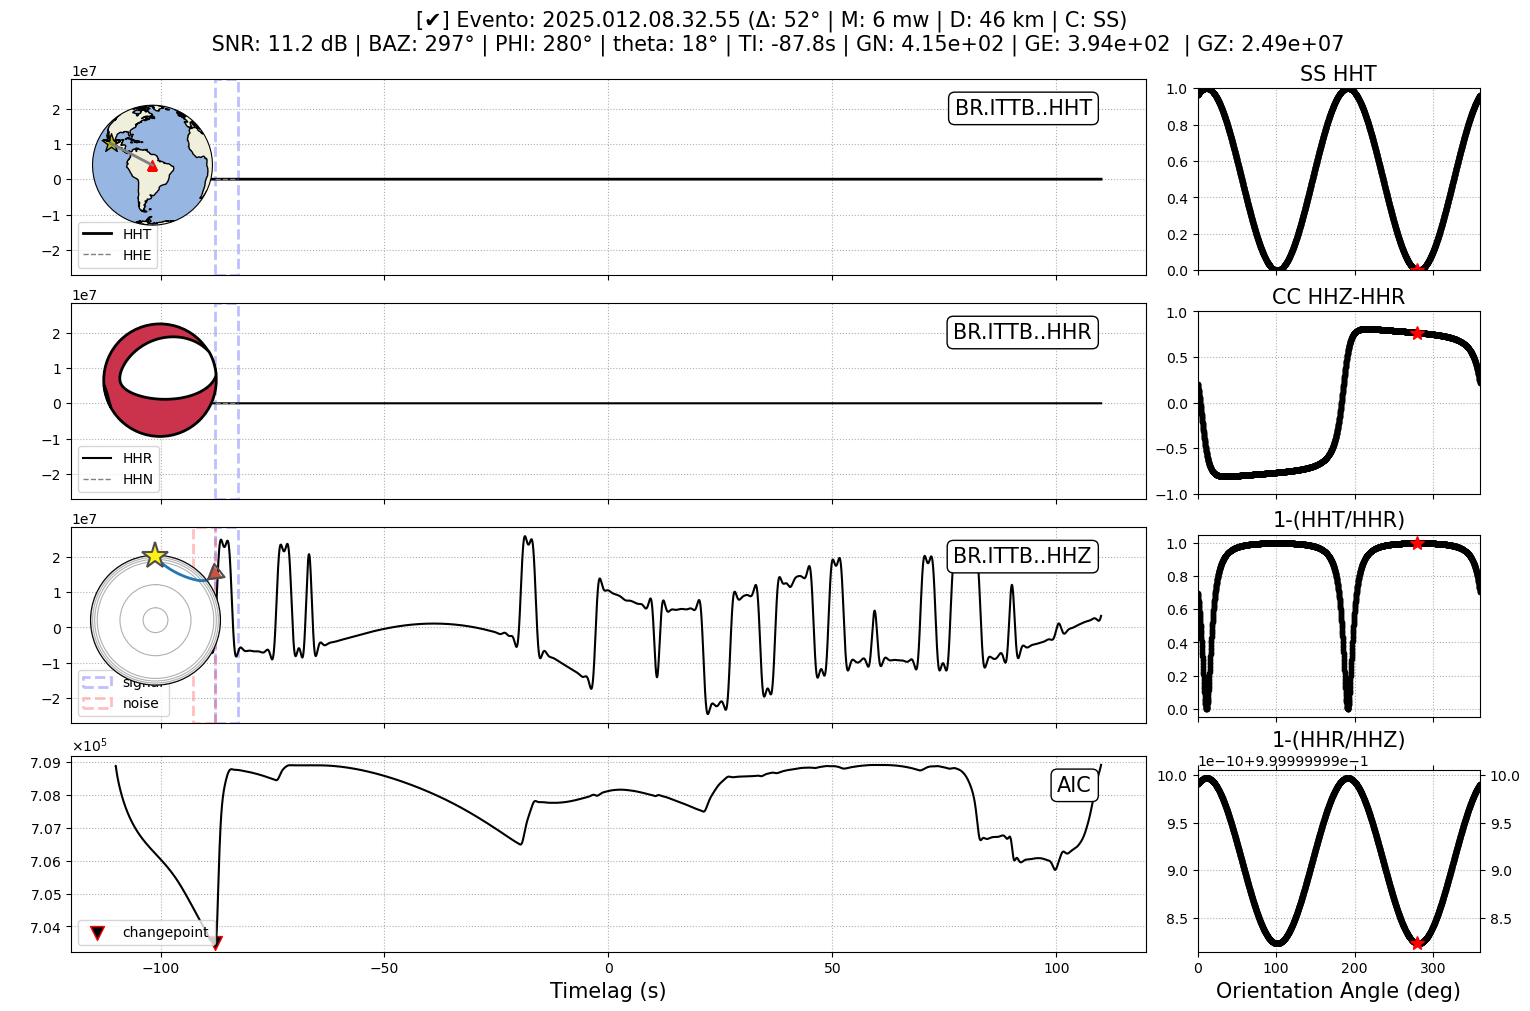

 63%|█████████████████████████▋               | 433/690 [01:07<01:09,  3.69it/s]

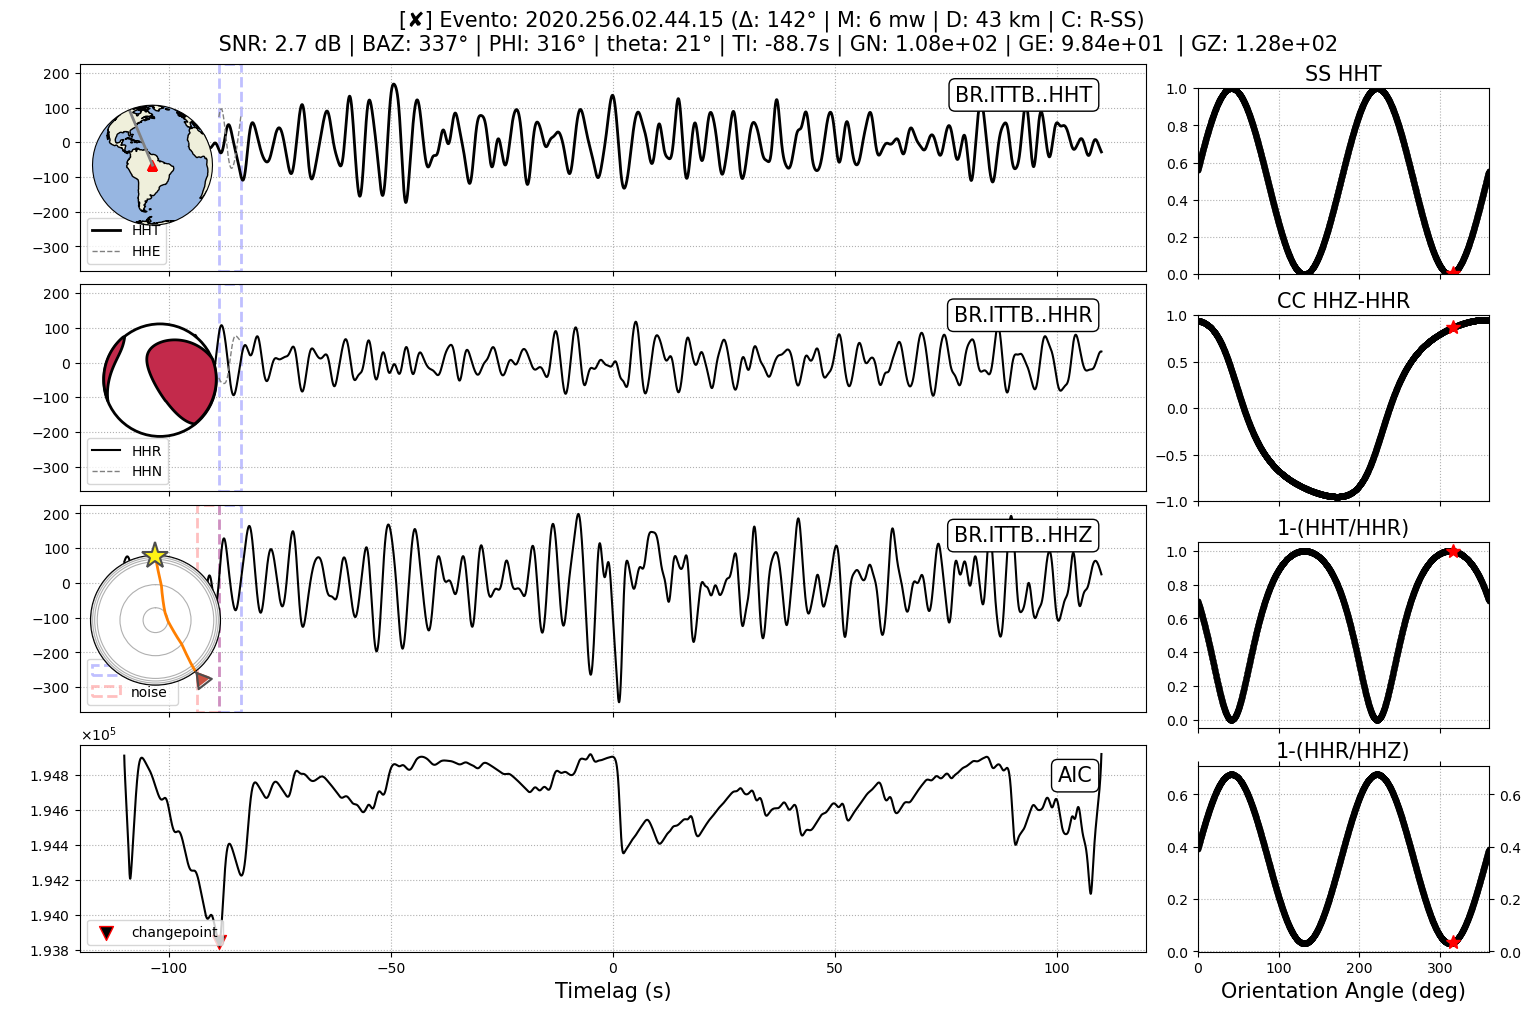

 66%|██████████████████████████▉              | 454/690 [01:10<00:55,  4.28it/s]

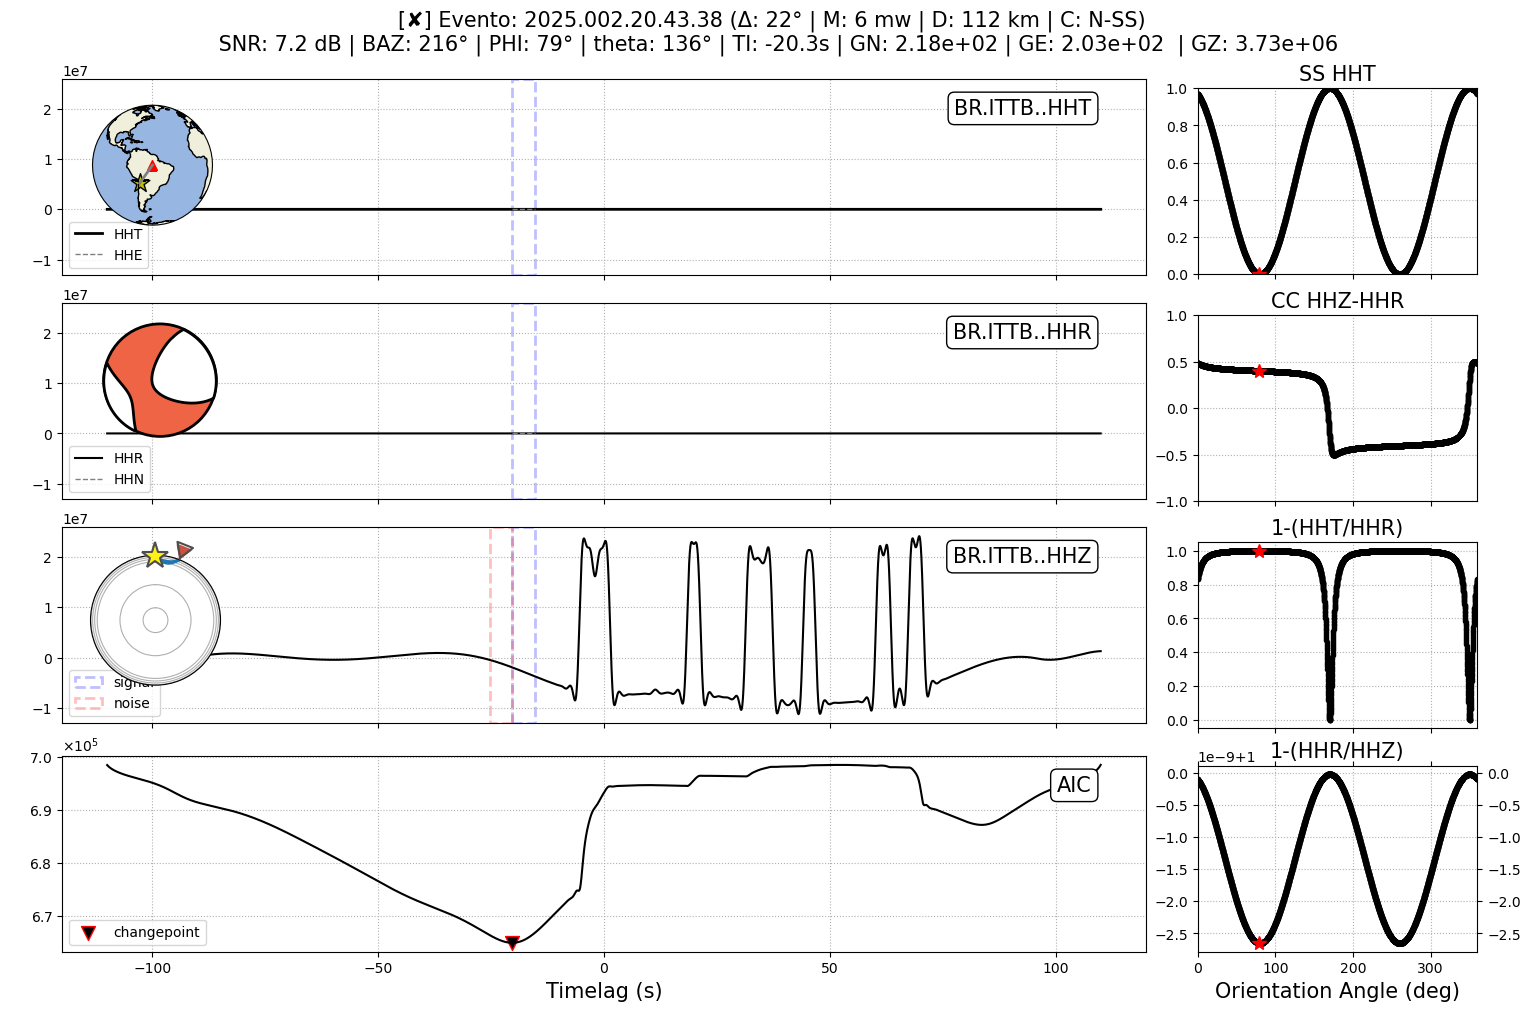

 69%|████████████████████████████▏            | 474/690 [01:13<00:54,  3.94it/s]

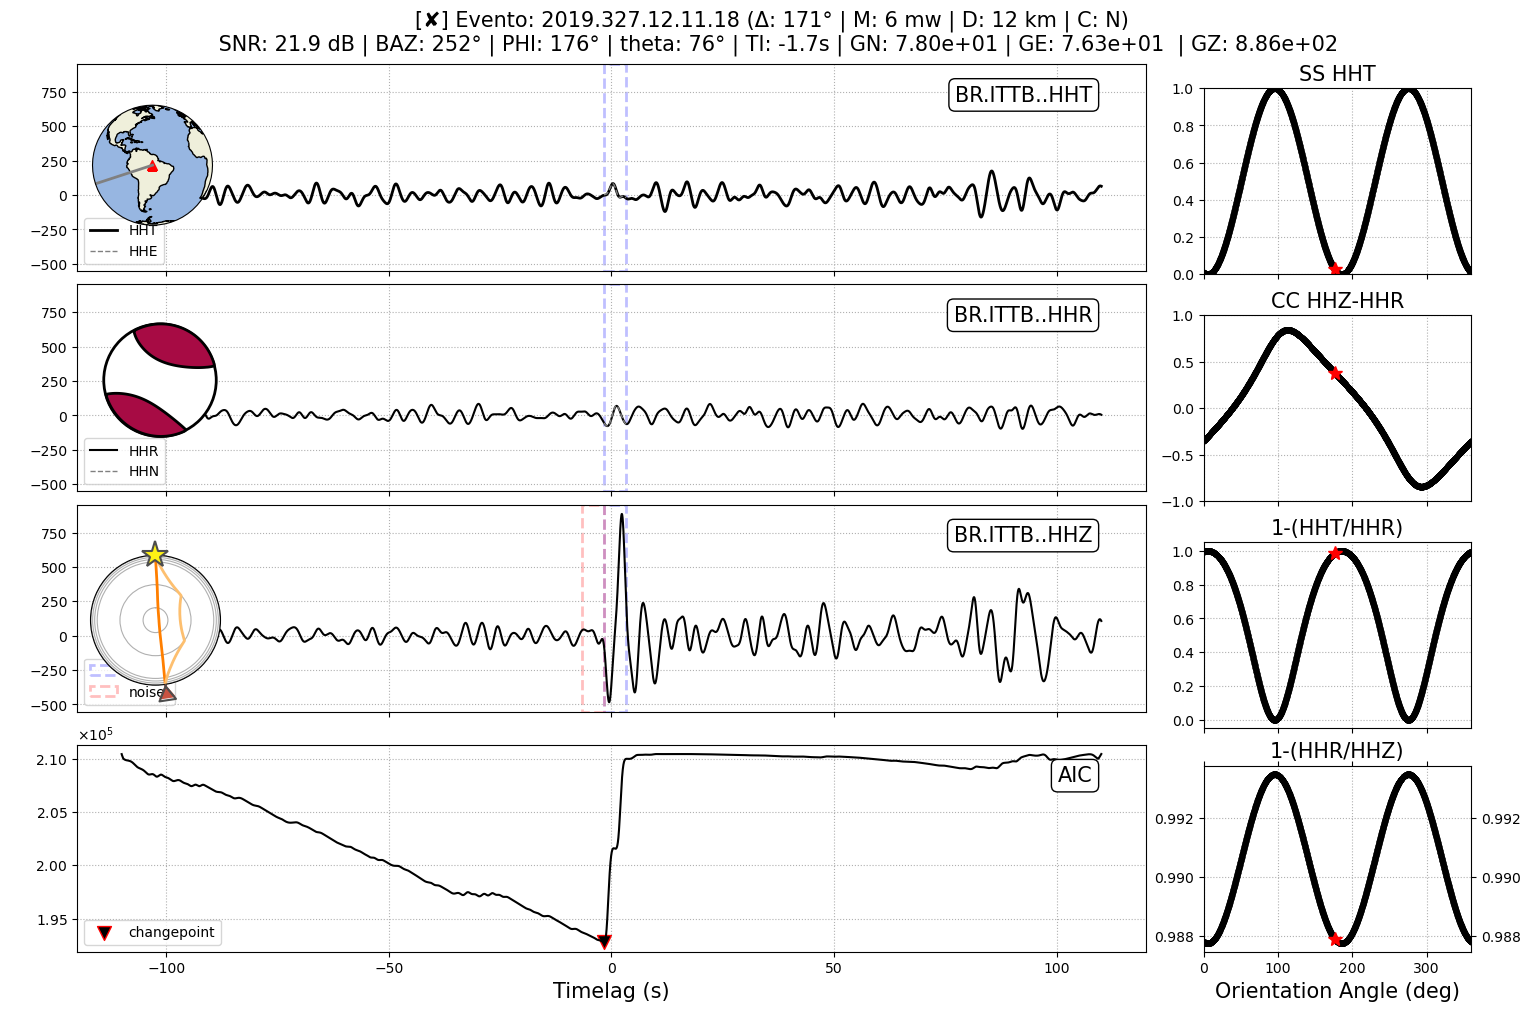

 71%|█████████████████████████████▎           | 493/690 [01:16<00:29,  6.77it/s]

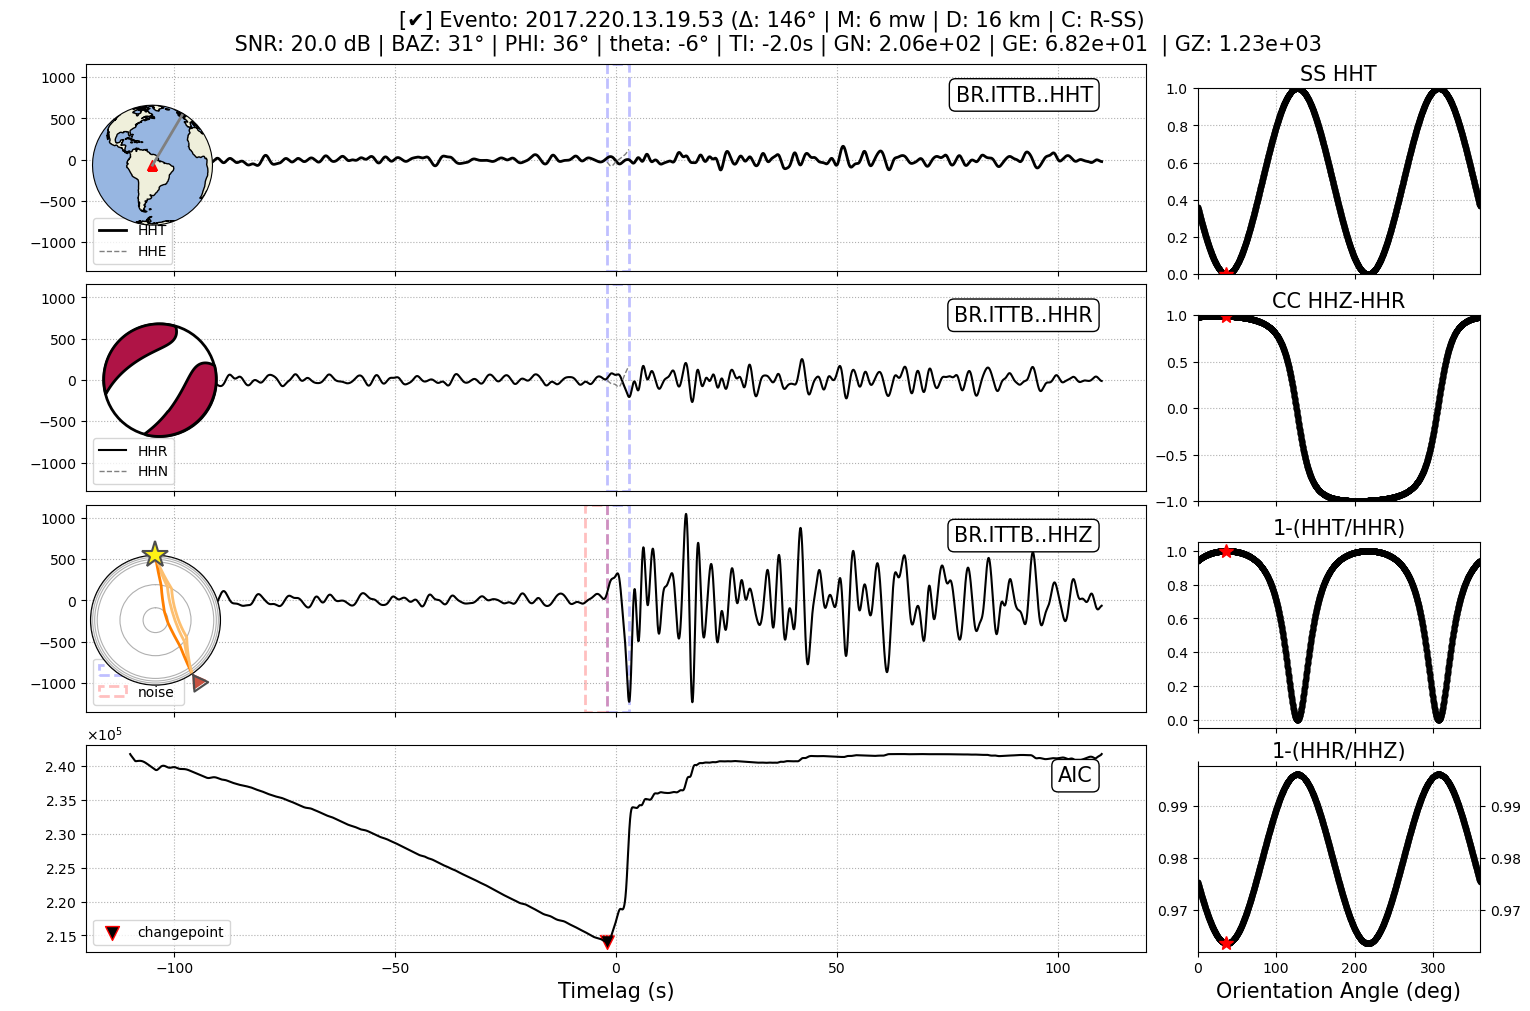

 74%|██████████████████████████████▌          | 514/690 [01:19<00:33,  5.31it/s]

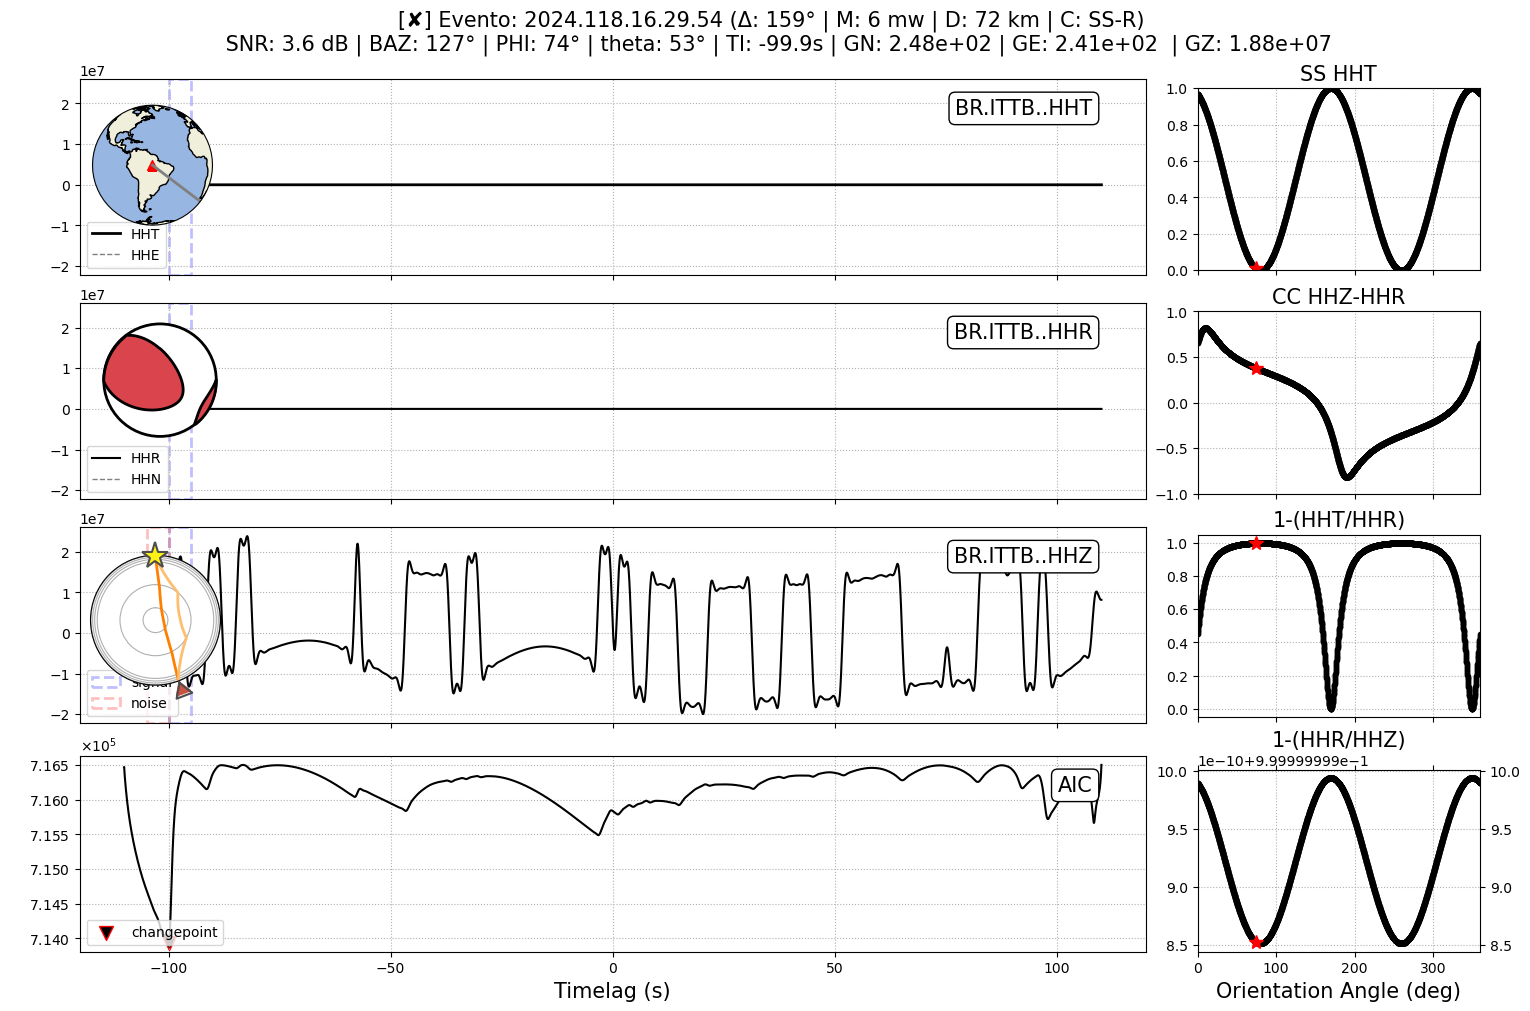

 77%|███████████████████████████████▌         | 532/690 [01:23<00:29,  5.36it/s]

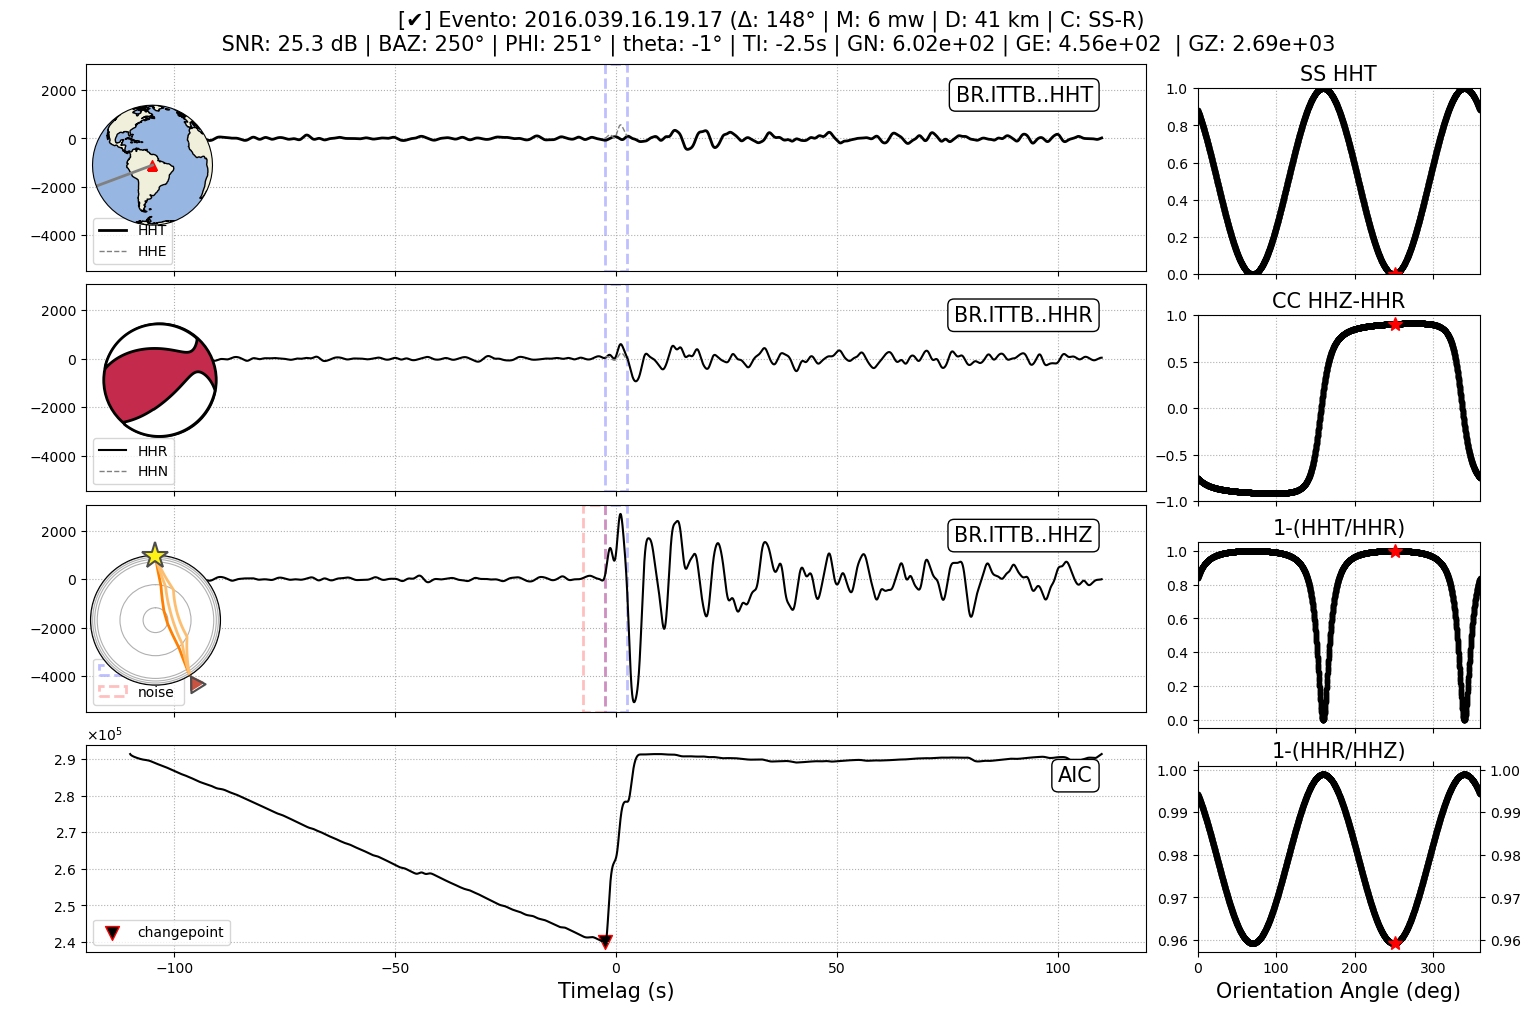

 80%|████████████████████████████████▋        | 550/690 [01:25<00:20,  6.84it/s]

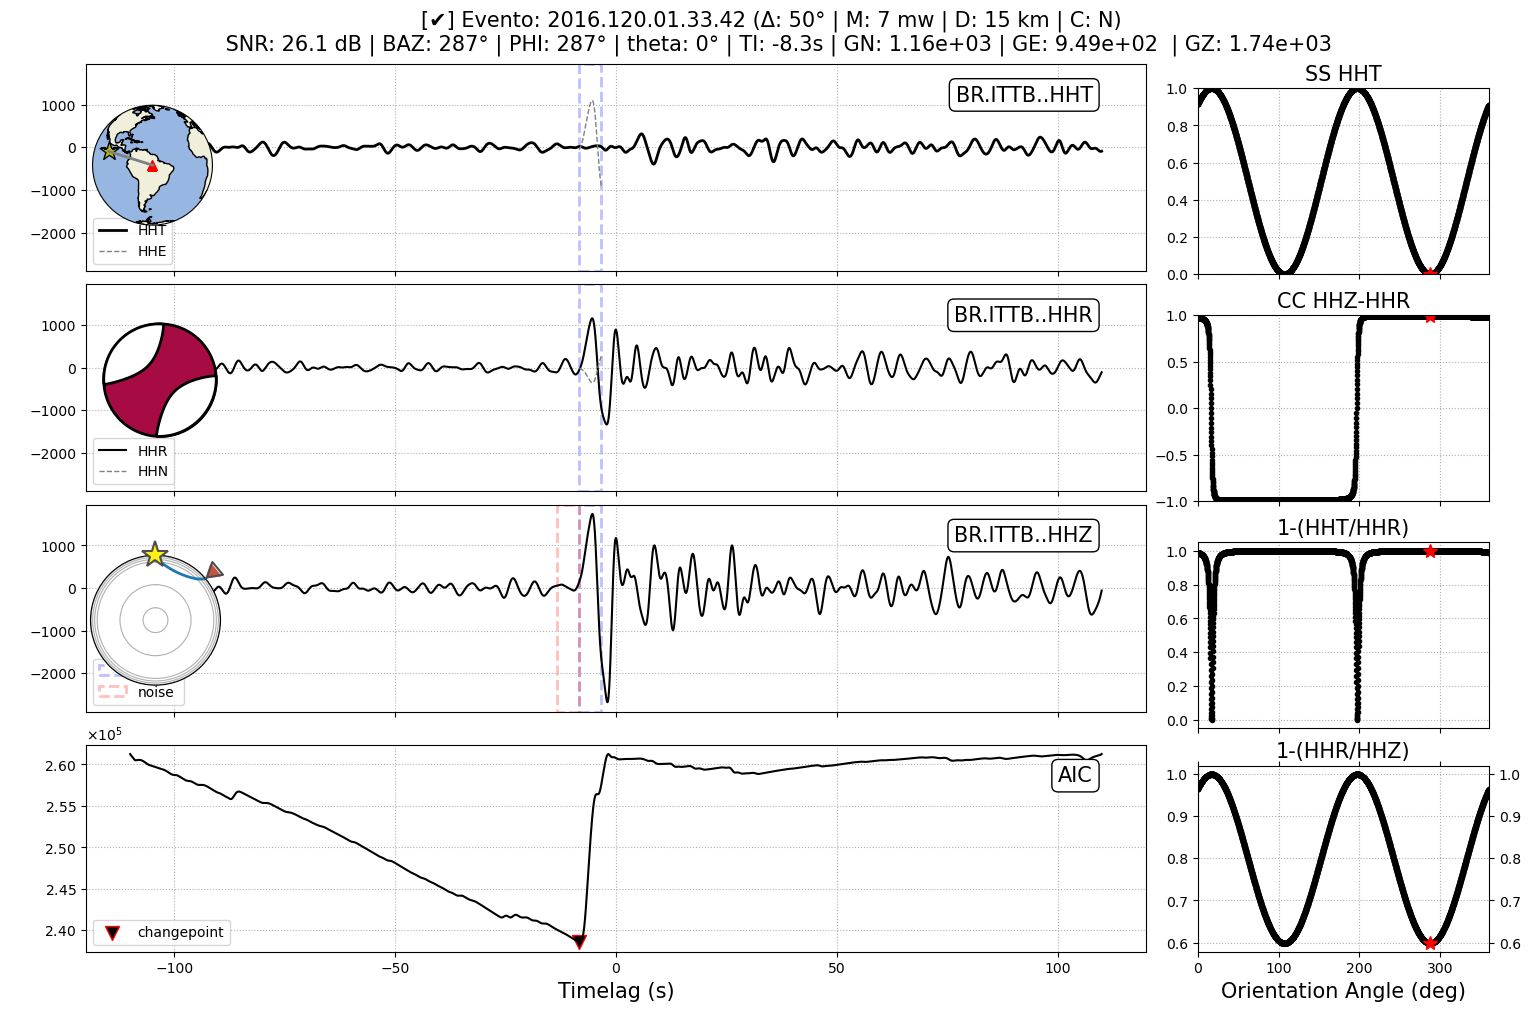

 83%|█████████████████████████████████▉       | 571/690 [01:29<00:19,  6.26it/s]

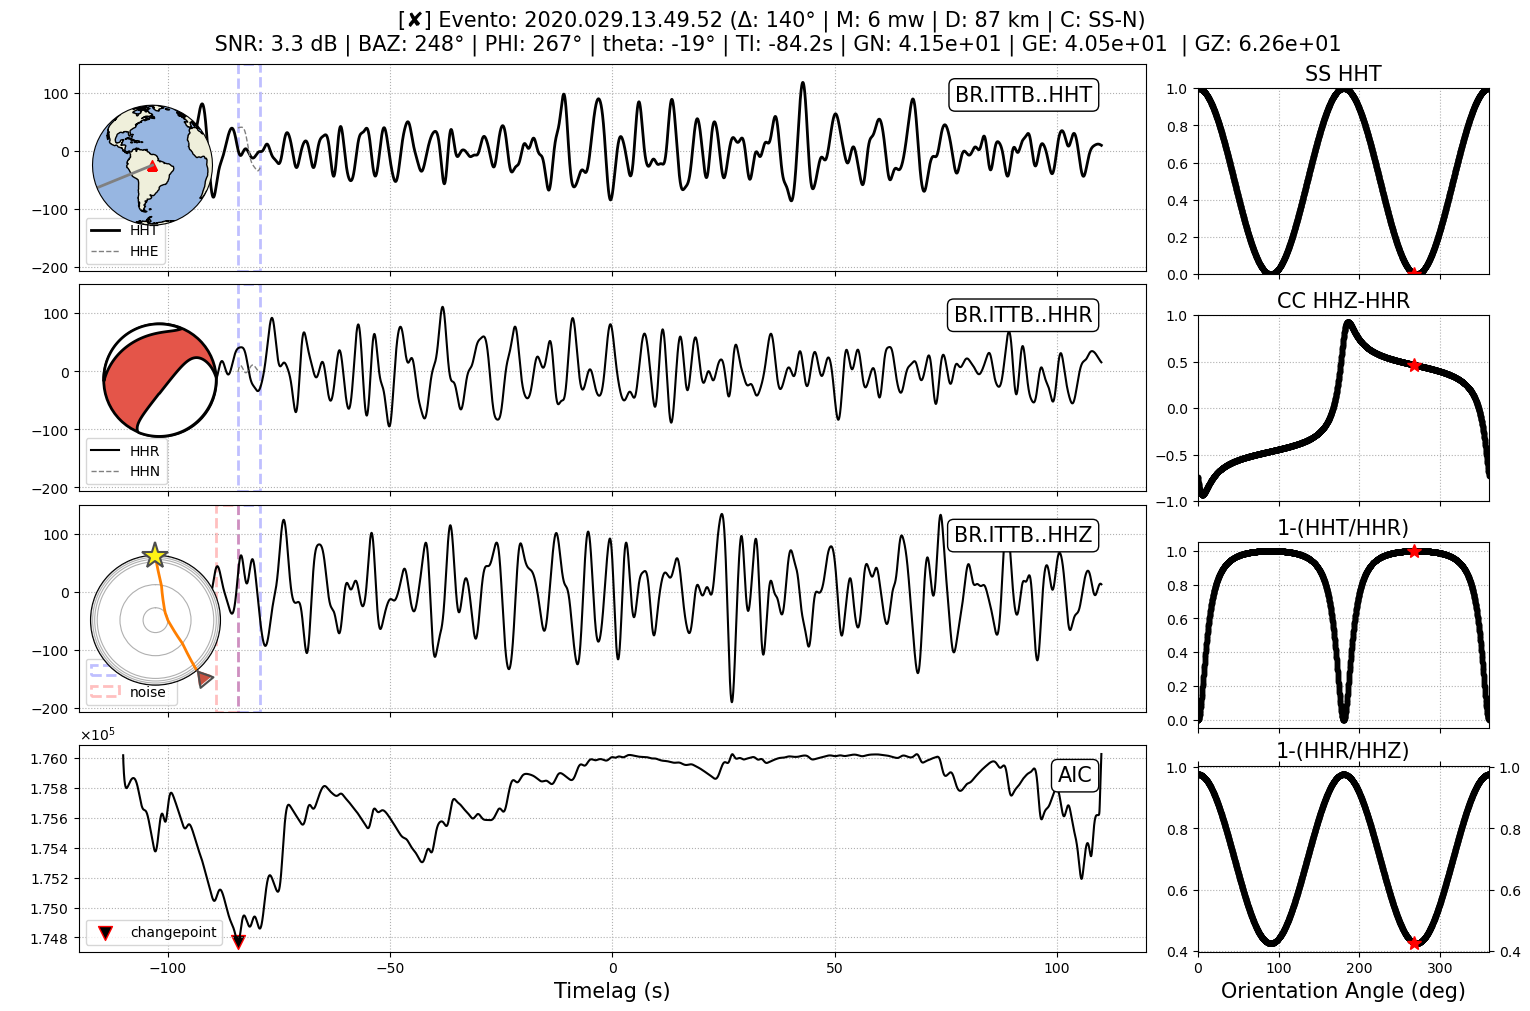

 87%|███████████████████████████████████▍     | 597/690 [01:33<00:16,  5.62it/s]

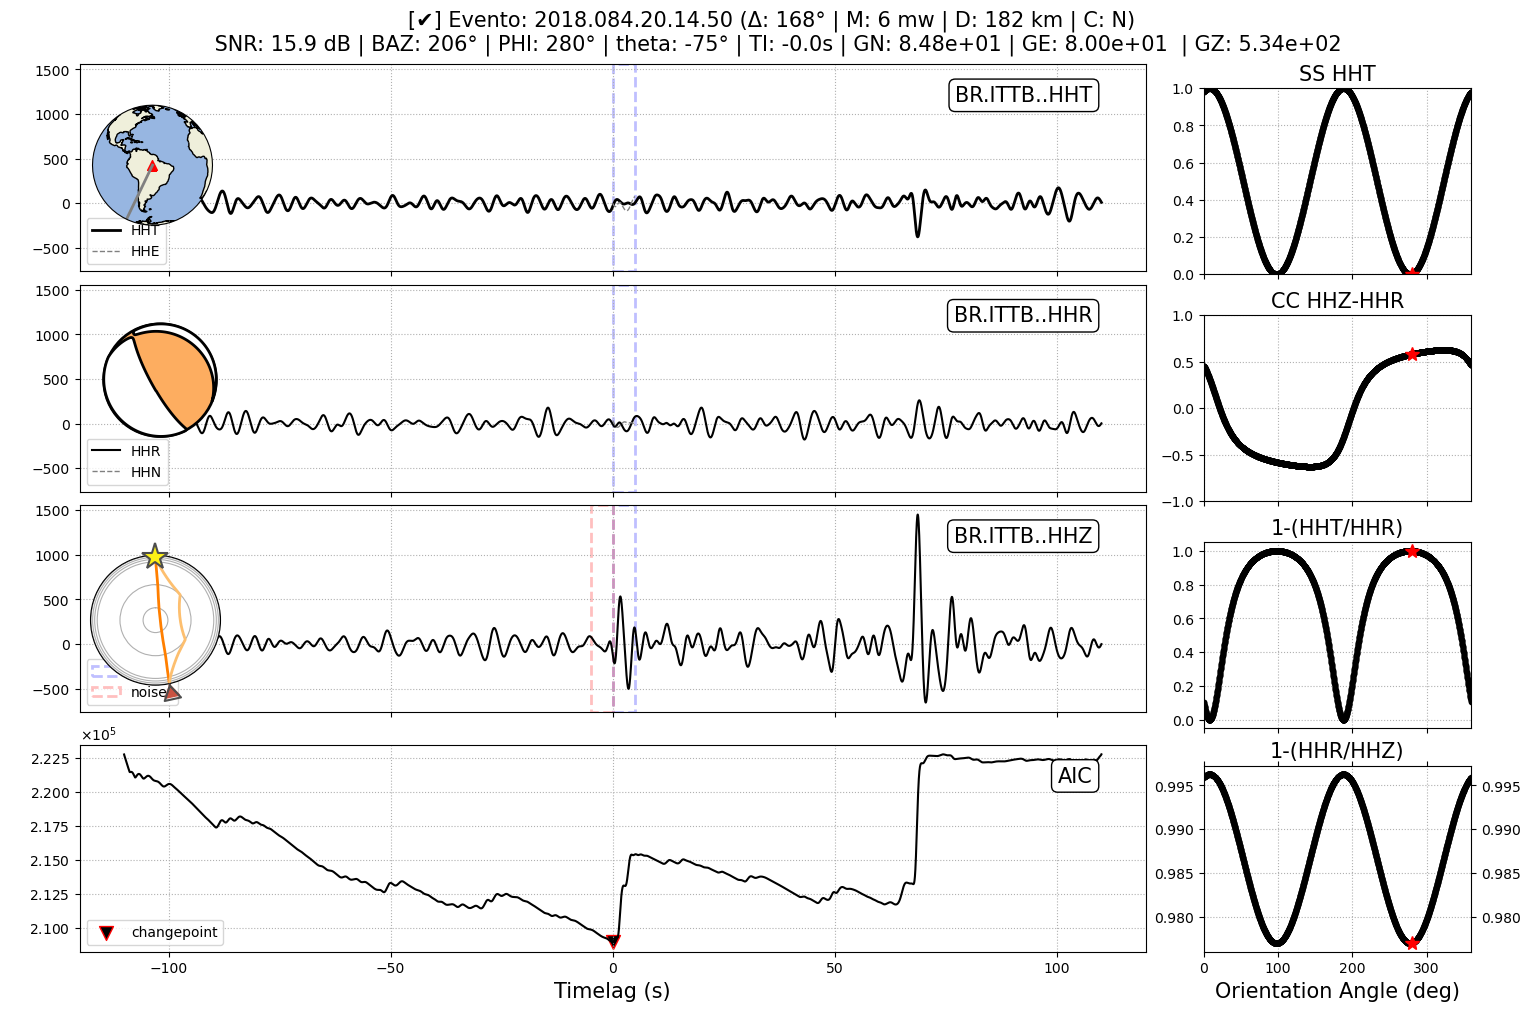

 90%|████████████████████████████████████▋    | 618/690 [01:37<00:17,  4.13it/s]

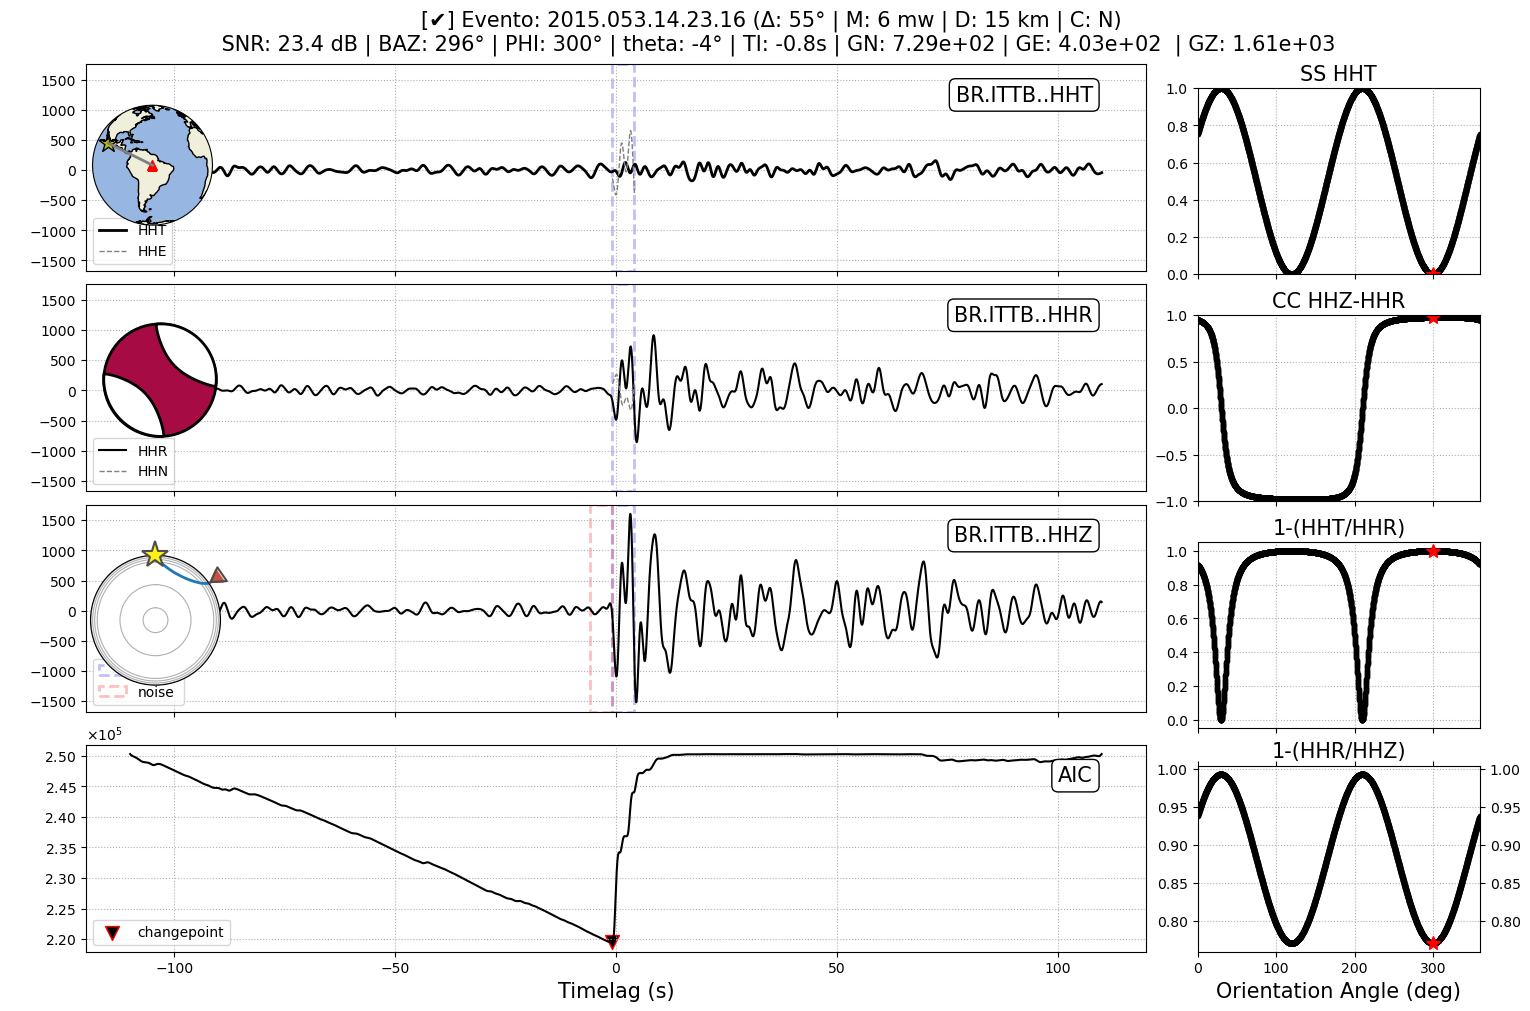

 93%|██████████████████████████████████████▎  | 644/690 [01:41<00:07,  6.47it/s]

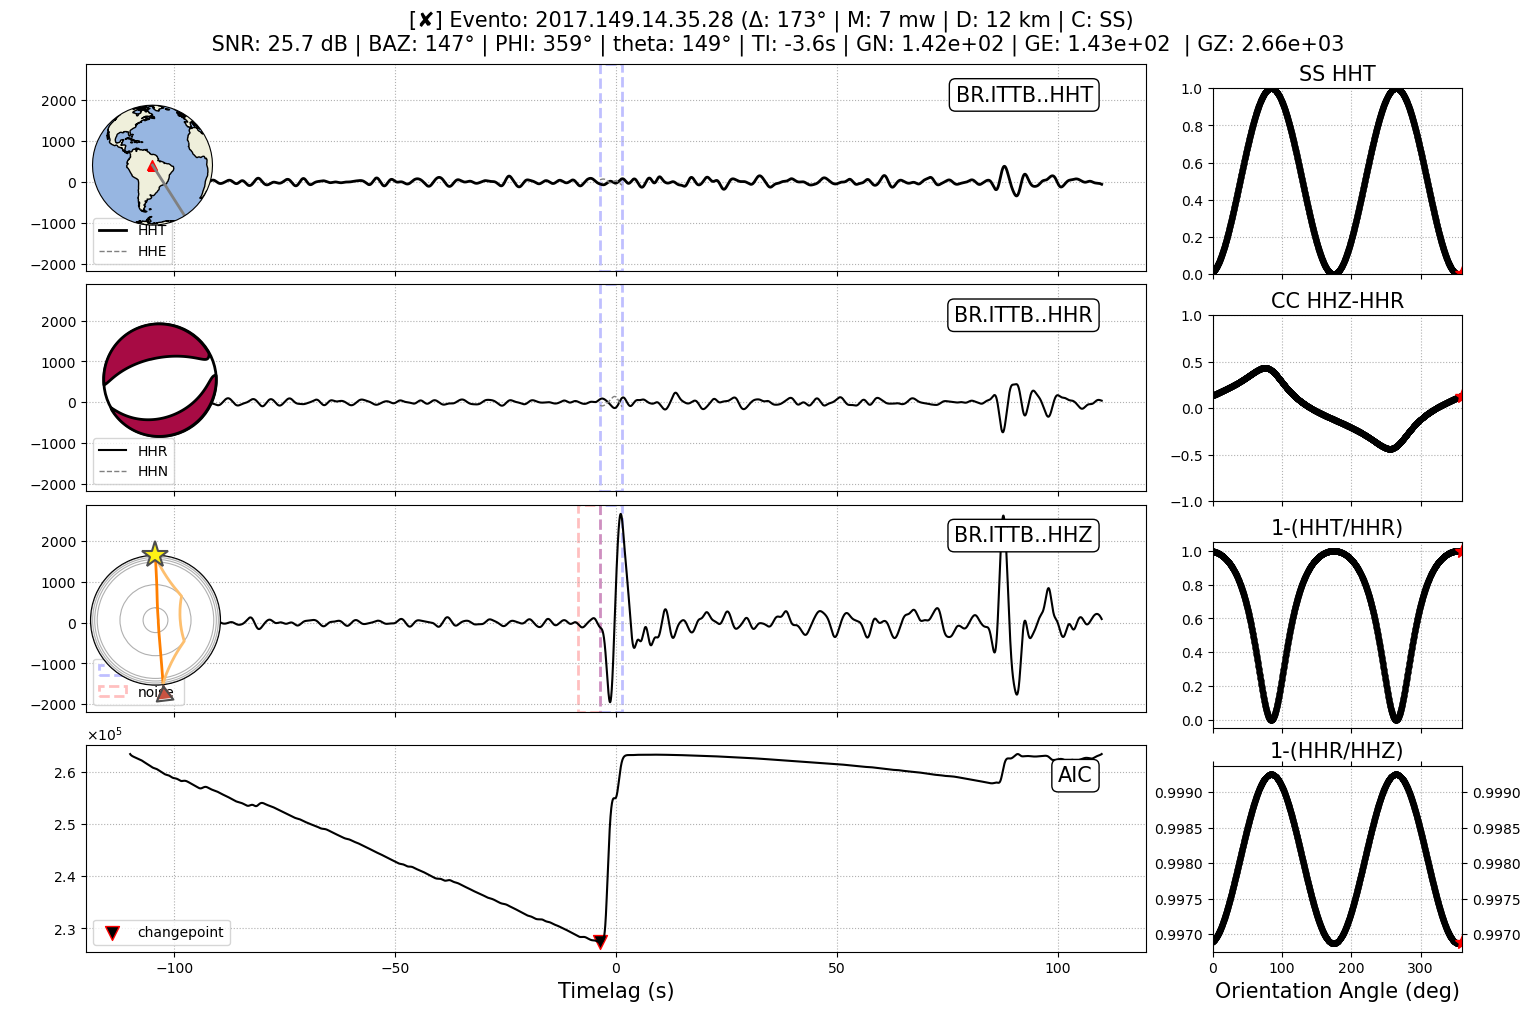

 97%|███████████████████████████████████████▋ | 667/690 [01:45<00:04,  5.02it/s]

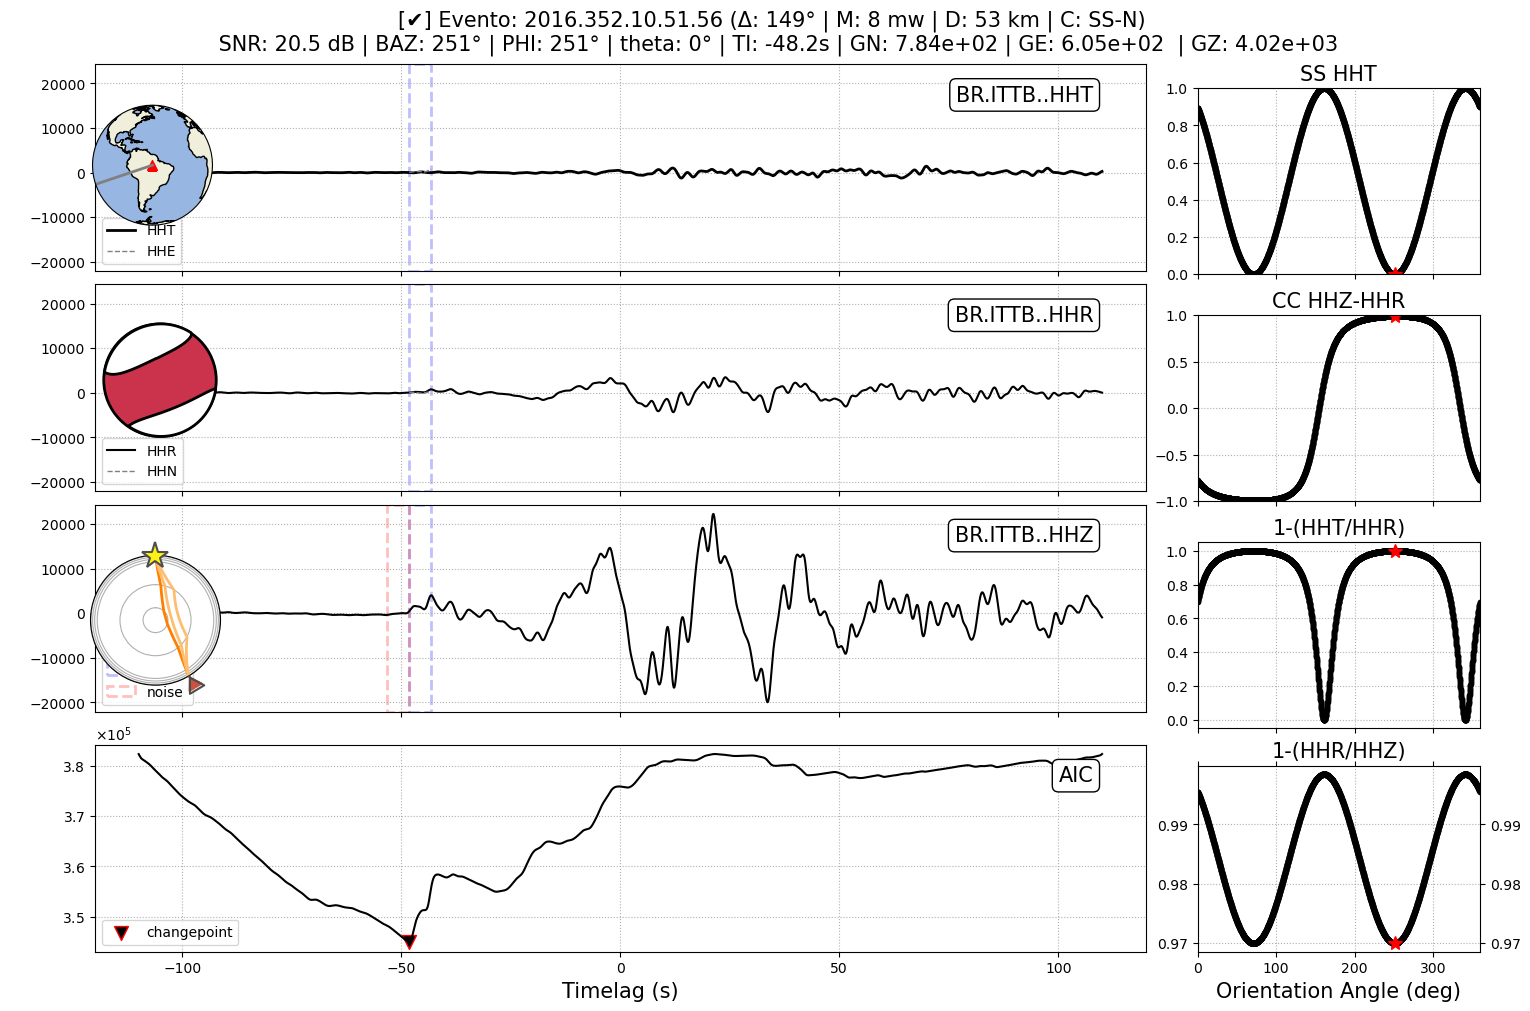

100%|█████████████████████████████████████████| 690/690 [01:48<00:00,  6.34it/s]



--- 1.84 execution time (min) ---




In [12]:
start_time = time.time()

for sta in STATIONS_lst:
    print('Processsing station: ',sta)
    FEATHER_FILES_LST = [pd.read_feather(i) for i in glob.glob(ORIENTATION_OUTPUT+'FEATHER_FILES/ORIENTATION/*'+sta+'/*')]
    station_df = pd.concat(FEATHER_FILES_LST)

    with Pool(processes=20) as p:
        max_ = len(station_df)
        with tqdm(total=max_) as pbar:
            for result in p.imap_unordered(plotting_event_orientation,station_df.iterrows()):
                pbar.update()

print('\n')
print("--- %.2f execution time (min) ---" % ((time.time() - start_time)/60))
print('\n')